### Henry Tessier
### Spark Assignment
### NCAA Basketball Data

In [54]:
import pyspark
from pyspark.ml.linalg import Vectors, VectorUDT 
import pandas as pd

In [2]:
conf = pyspark.SparkConf().setAppName('ncaa').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

In [3]:
sc

<SparkContext master=local appName=ncaa>

In [4]:
datapath = '2018NCAAData.csv'

In [5]:
ncaa = sqlc.read.format("csv").option("header","true").option("inferSchema", "true").load(datapath)

In [6]:
ncaa.printSchema()

root
 |-- Team: string (nullable = true)
 |-- Rank: integer (nullable = true)
 |-- Actual_Seed: integer (nullable = true)
 |-- Wins: integer (nullable = true)
 |-- Losses: integer (nullable = true)
 |-- AdjEM: double (nullable = true)
 |-- SOS_Pyth: double (nullable = true)
 |-- Conference: string (nullable = true)



### Convert to Parquet

In [7]:
parquetPath = '/home/ec2-user/SageMaker/Open-Data-Lab/education/hmt6ra'
#ncaa.write.parquet(parquetPath)

In [8]:
data = sqlc.read.parquet(parquetPath)
display(data)

DataFrame[Team: string, Rank: int, Actual_Seed: int, Wins: int, Losses: int, AdjEM: double, SOS_Pyth: double, Conference: string]

In [9]:
data.show()

+--------------+----+-----------+----+------+-----+--------+----------+
|          Team|Rank|Actual_Seed|Wins|Losses|AdjEM|SOS_Pyth|Conference|
+--------------+----+-----------+----+------+-----+--------+----------+
|      Virginia|   1|          1|  31|     2|32.15|    9.99|       ACC|
|     Villanova|   2|          1|  30|     4|31.41|   10.23|        BE|
|          Duke|   3|          2|  26|     7|29.13|    10.9|       ACC|
|        Purdue|   4|          2|  28|     6|26.67|    8.55|       B10|
|North_Carolina|   5|          2|  25|    10|25.03|   14.05|       ACC|
|   Michigan_St|   6|          3|  29|     4|26.35|     6.5|       B10|
|        Kansas|   7|          1|  27|     7|23.24|   11.49|       B12|
|    Cincinnati|   8|          2|  30|     4| 27.0|    3.18|      Amer|
|        Xavier|   9|          1|  28|     5|21.69|    9.62|        BE|
|     Tennessee|  10|          3|  25|     8|22.15|   11.62|       SEC|
|      Michigan|  11|          3|  28|     7|23.19|    8.78|    

### Create new column (Win Percentage)

In [10]:
data = data.withColumn('WinPct', data.Wins / (data.Wins + data.Losses))

In [11]:
data.show()

+--------------+----+-----------+----+------+-----+--------+----------+------------------+
|          Team|Rank|Actual_Seed|Wins|Losses|AdjEM|SOS_Pyth|Conference|            WinPct|
+--------------+----+-----------+----+------+-----+--------+----------+------------------+
|      Virginia|   1|          1|  31|     2|32.15|    9.99|       ACC|0.9393939393939394|
|     Villanova|   2|          1|  30|     4|31.41|   10.23|        BE|0.8823529411764706|
|          Duke|   3|          2|  26|     7|29.13|    10.9|       ACC|0.7878787878787878|
|        Purdue|   4|          2|  28|     6|26.67|    8.55|       B10|0.8235294117647058|
|North_Carolina|   5|          2|  25|    10|25.03|   14.05|       ACC|0.7142857142857143|
|   Michigan_St|   6|          3|  29|     4|26.35|     6.5|       B10|0.8787878787878788|
|        Kansas|   7|          1|  27|     7|23.24|   11.49|       B12|0.7941176470588235|
|    Cincinnati|   8|          2|  30|     4| 27.0|    3.18|      Amer|0.8823529411764706|

In [12]:
print("Pearson's r(Strength of Schedule, Win Percent) = {}".format(data.corr("SOS_Pyth", "WinPct")))
print("")
print("Pearson's r(Adjusted Efficiency, Win Percent) = {}".format(data.corr("AdjEM", "WinPct")))

Pearson's r(Strength of Schedule, Win Percent) = 0.2657849446230867

Pearson's r(Adjusted Efficiency, Win Percent) = 0.8270958381984828


In [13]:
data = data.select("WinPct", "SOS_Pyth", "AdjEM", "Rank")

### Train and Test Split

In [14]:
seed = 62
(testDF, trainingDF) = data.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 285, test set N = 66


In [16]:
from pyspark.ml.feature import VectorAssembler

In [17]:
assembler = VectorAssembler(
    inputCols=["SOS_Pyth", "AdjEM", "Rank"],
    outputCol="features")

In [41]:
vecTrain = assembler.transform(trainingDF)
vecTest = assembler.transform(testDF)

In [44]:
trainingDF = vecTrain.selectExpr("WinPct as label", "features")
testDF = vecTest.selectExpr("WinPct as label", "features")

### Linear Regression to predict Win Percentage

In [47]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

In [48]:
lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [49]:
predictions = lrModel.transform(testDF)

In [51]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


### View R^2, Coefficients, and Intercept

In [52]:
eval.setMetricName("r2").evaluate(predictions)

0.9061519304154868

In [58]:
print("coefficients: " + str(lrModel.coefficients))
print("intercept: " + str(lrModel.intercept))

coefficients: [-0.02235865657937017,0.011511843550962755,-0.0010042426100046833]
intercept: 0.690567775337331


In [63]:
results = predictions.toPandas()

In [64]:
results.head()

,label,features,prediction
0,0.096774,"[-8.07, -28.57, 351.0]",0.189620
1,0.125000,"[-7.36, -24.4, 348.0]",0.224762
2,0.193548,"[-3.32, -17.65, 334.0]",0.226197
3,0.218750,"[-7.21, -26.96, 349.0]",0.190934
4,0.250000,"[-1.94, -15.08, 322.0]",0.236979


In [65]:
results['resid'] = results.label - results.prediction

### View Residuals

In [101]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

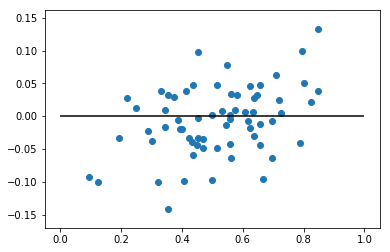

In [73]:
plt.scatter(results.label,results.resid)
plt.hlines(0, 0, 1)

### SQL Query to get Conference Ratings

In [74]:
ncaa.registerTempTable("ncaa")

In [77]:
ncaa.show()

+--------------+----+-----------+----+------+-----+--------+----------+
|          Team|Rank|Actual_Seed|Wins|Losses|AdjEM|SOS_Pyth|Conference|
+--------------+----+-----------+----+------+-----+--------+----------+
|      Virginia|   1|          1|  31|     2|32.15|    9.99|       ACC|
|     Villanova|   2|          1|  30|     4|31.41|   10.23|        BE|
|          Duke|   3|          2|  26|     7|29.13|    10.9|       ACC|
|        Purdue|   4|          2|  28|     6|26.67|    8.55|       B10|
|North_Carolina|   5|          2|  25|    10|25.03|   14.05|       ACC|
|   Michigan_St|   6|          3|  29|     4|26.35|     6.5|       B10|
|        Kansas|   7|          1|  27|     7|23.24|   11.49|       B12|
|    Cincinnati|   8|          2|  30|     4| 27.0|    3.18|      Amer|
|        Xavier|   9|          1|  28|     5|21.69|    9.62|        BE|
|     Tennessee|  10|          3|  25|     8|22.15|   11.62|       SEC|
|      Michigan|  11|          3|  28|     7|23.19|    8.78|    

In [90]:
Conf = sqlc.sql(""" SELECT Conference, Round(Mean(AdjEM),2) as Rating FROM ncaa Group By Conference Order By Rating DESC """)

In [92]:
OrdConf = Conf.toPandas()

<BarContainer object of 32 artists>

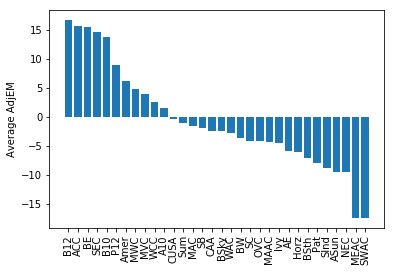

In [115]:
plt.xticks(rotation=90)
plt.ylabel('Average AdjEM')
plt.bar(OrdConf.Conference, OrdConf.Rating)